# Logfile Reconstructoin

Reconstructing timestamp using the logfile. We identify the regions of interest, and the UTC times they occur in and then proceed with plugging them back to the data and fixing the time.

In [1]:
# import necessary modules
import matplotlib.pyplot as plt
import raadpy as rp
import numpy as np
import os

# Define some constants
# raw_dir = '../../Data/RAW/'
SD      = '2022-09-07'
raw_dir = '../../Data/Light-1/light1-'+SD+'/'

# Get the subfiles and put the in a dictionary
fnames      = os.listdir(raw_dir)
filenames   = {}
for i in range(1,10): 
    res = [name for name in fnames if f'buff{i}' in name]
    if len(res)>0: filenames[f'buff{i}'] = res[0]
for name in fnames: 
    if 'log' in name: filenames['log'] = name

print(filenames)

%matplotlib widget

{'buff1': 'light1-2022-09-10-buff1.dat', 'buff2': 'light1-2022-09-07-buff2.dat', 'buff3': 'light1-2022-09-07-buff3.dat', 'buff4': 'light1-2022-09-12-buff4.dat', 'buff5': 'light1-2022-09-13-buff5.dat', 'buff6': 'light1-2022-NA-NA-buff6.dat', 'buff7': 'light1-2022-NA-NA-buff7.dat', 'buff8': 'light1-2022-NA-NA-buff8.dat', 'buff9': 'light1-2022-NA-NA-buff9.dat', 'log': 'light1-2022-09-07-se-log.txt'}


In [2]:
# Directory of the buffer
# buffer_fname    = raw_dir + SD + '/light1-'+SD+'-buff1.dat'
# Or:
buffer_fname    = raw_dir + filenames['buff1']

# Decode the buffer data in a dictionary
data_SiPM   = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 1")
data_PMT    = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 0")

Line:   0%|          | 0/8534 [00:00<?, ?it/s]

Line:   0%|          | 0/8534 [00:00<?, ?it/s]

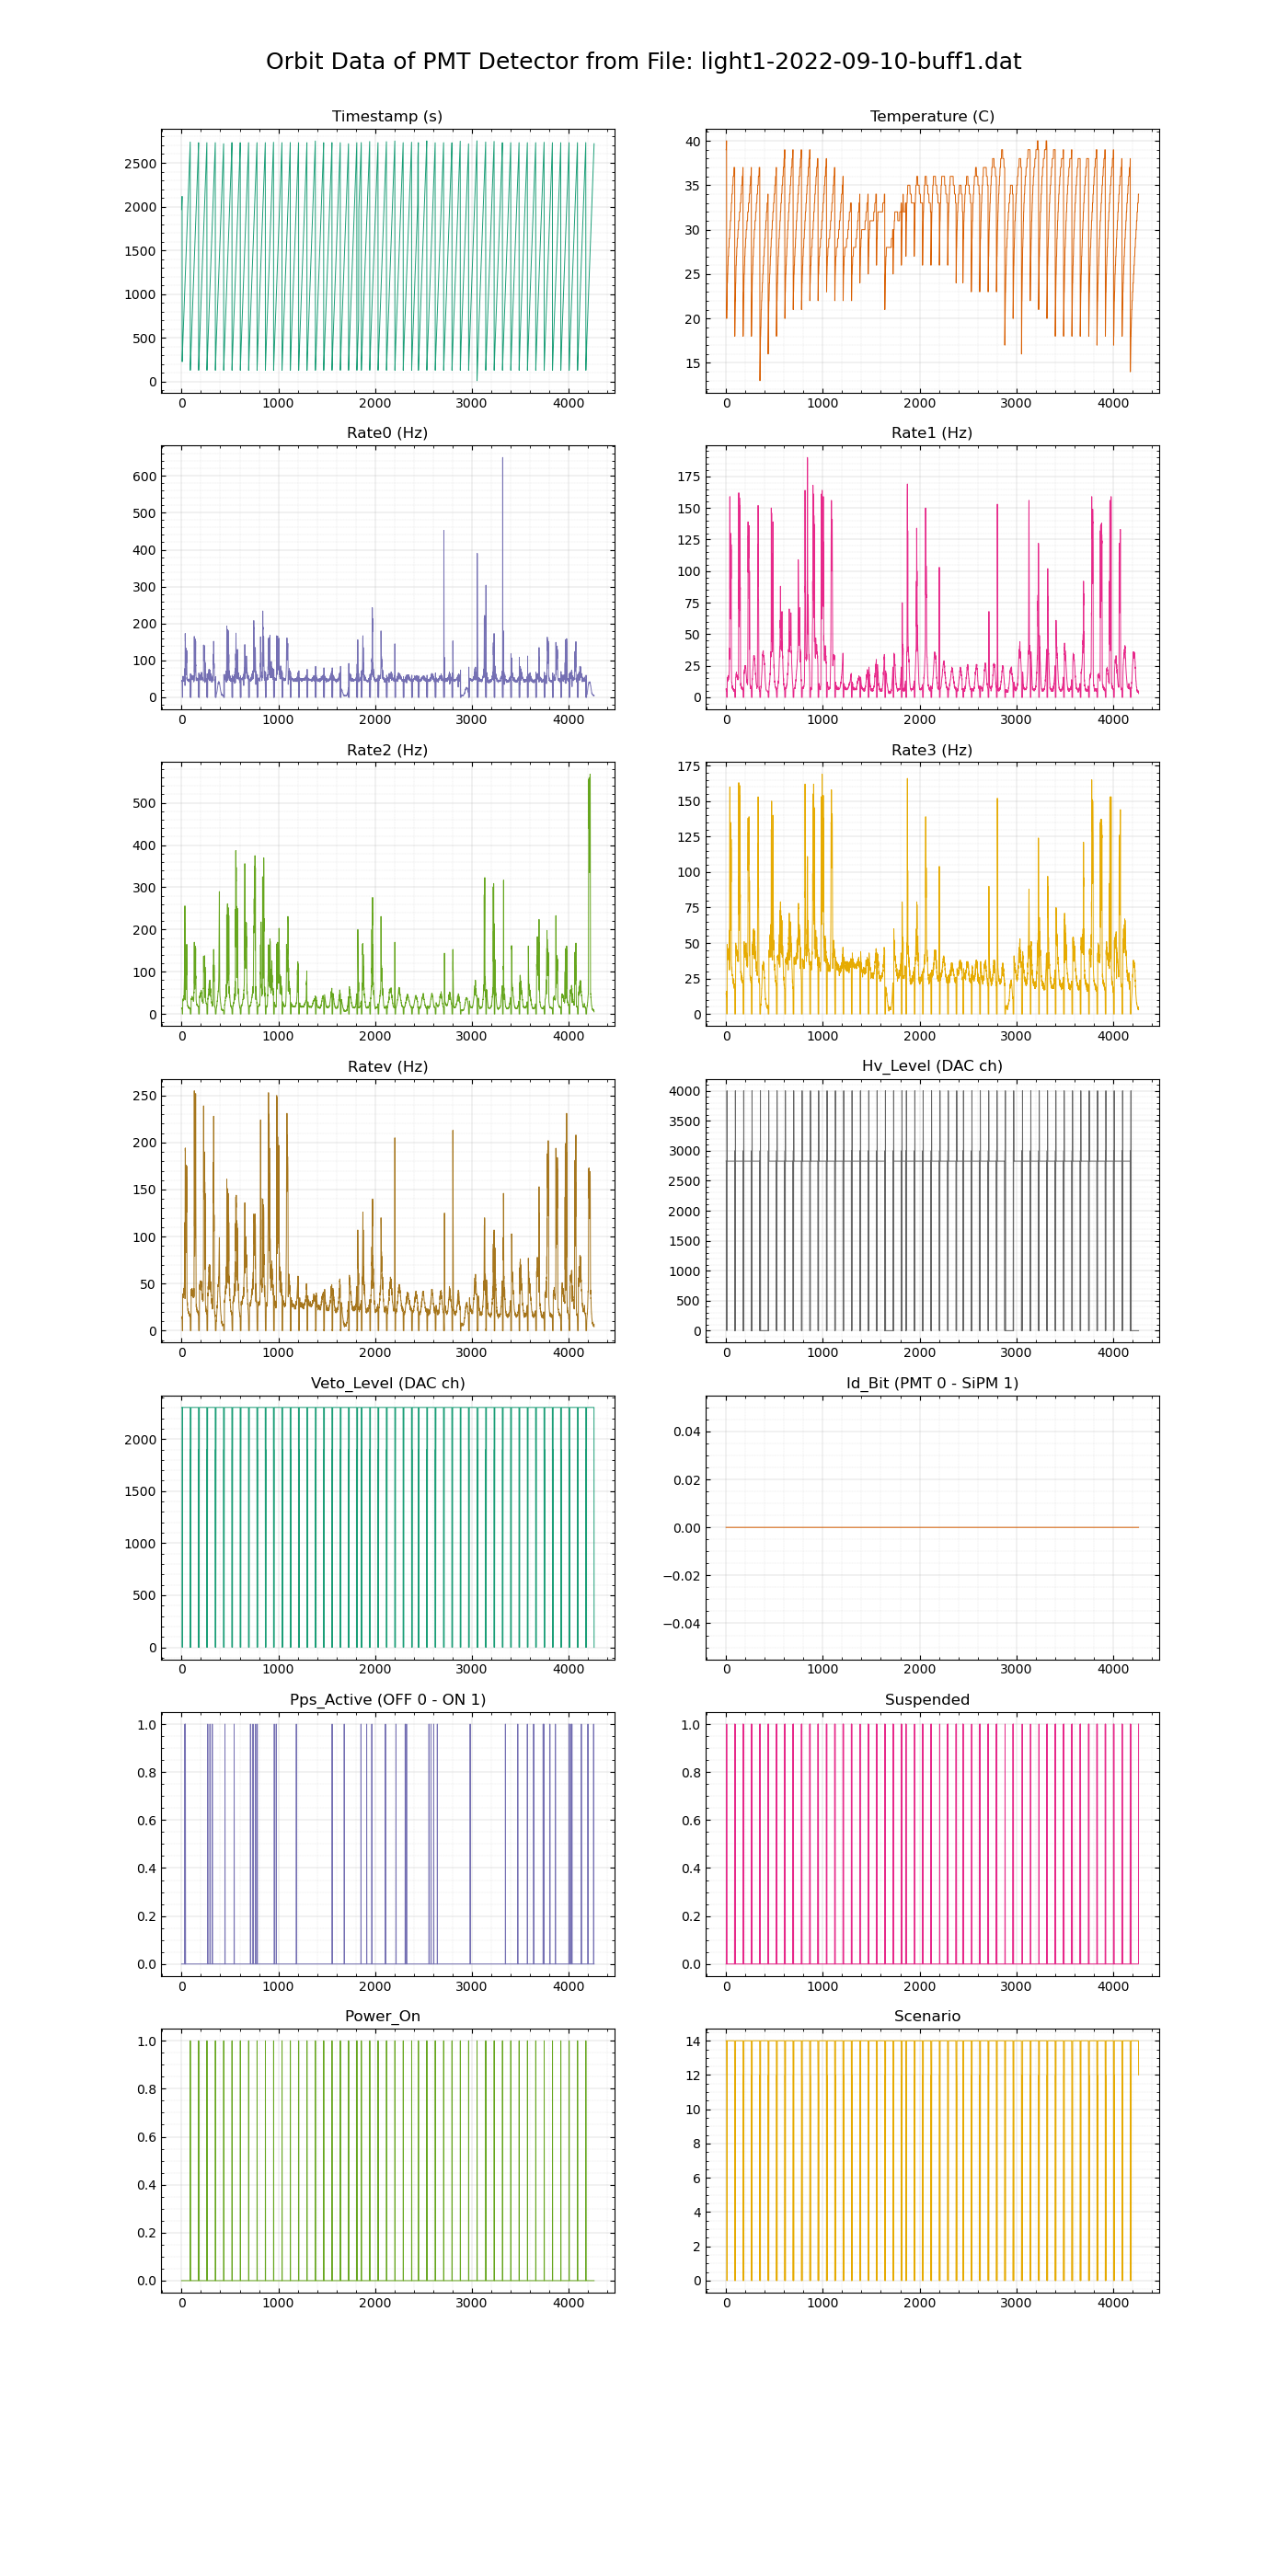

In [3]:
# Now print the PMT Data
fig, axes  = rp.plot_buffer(data_PMT,title = 'Orbit Data of PMT Detector from File: '+ filenames['buff1'],UNITS=rp.ORBIT_UNITS)

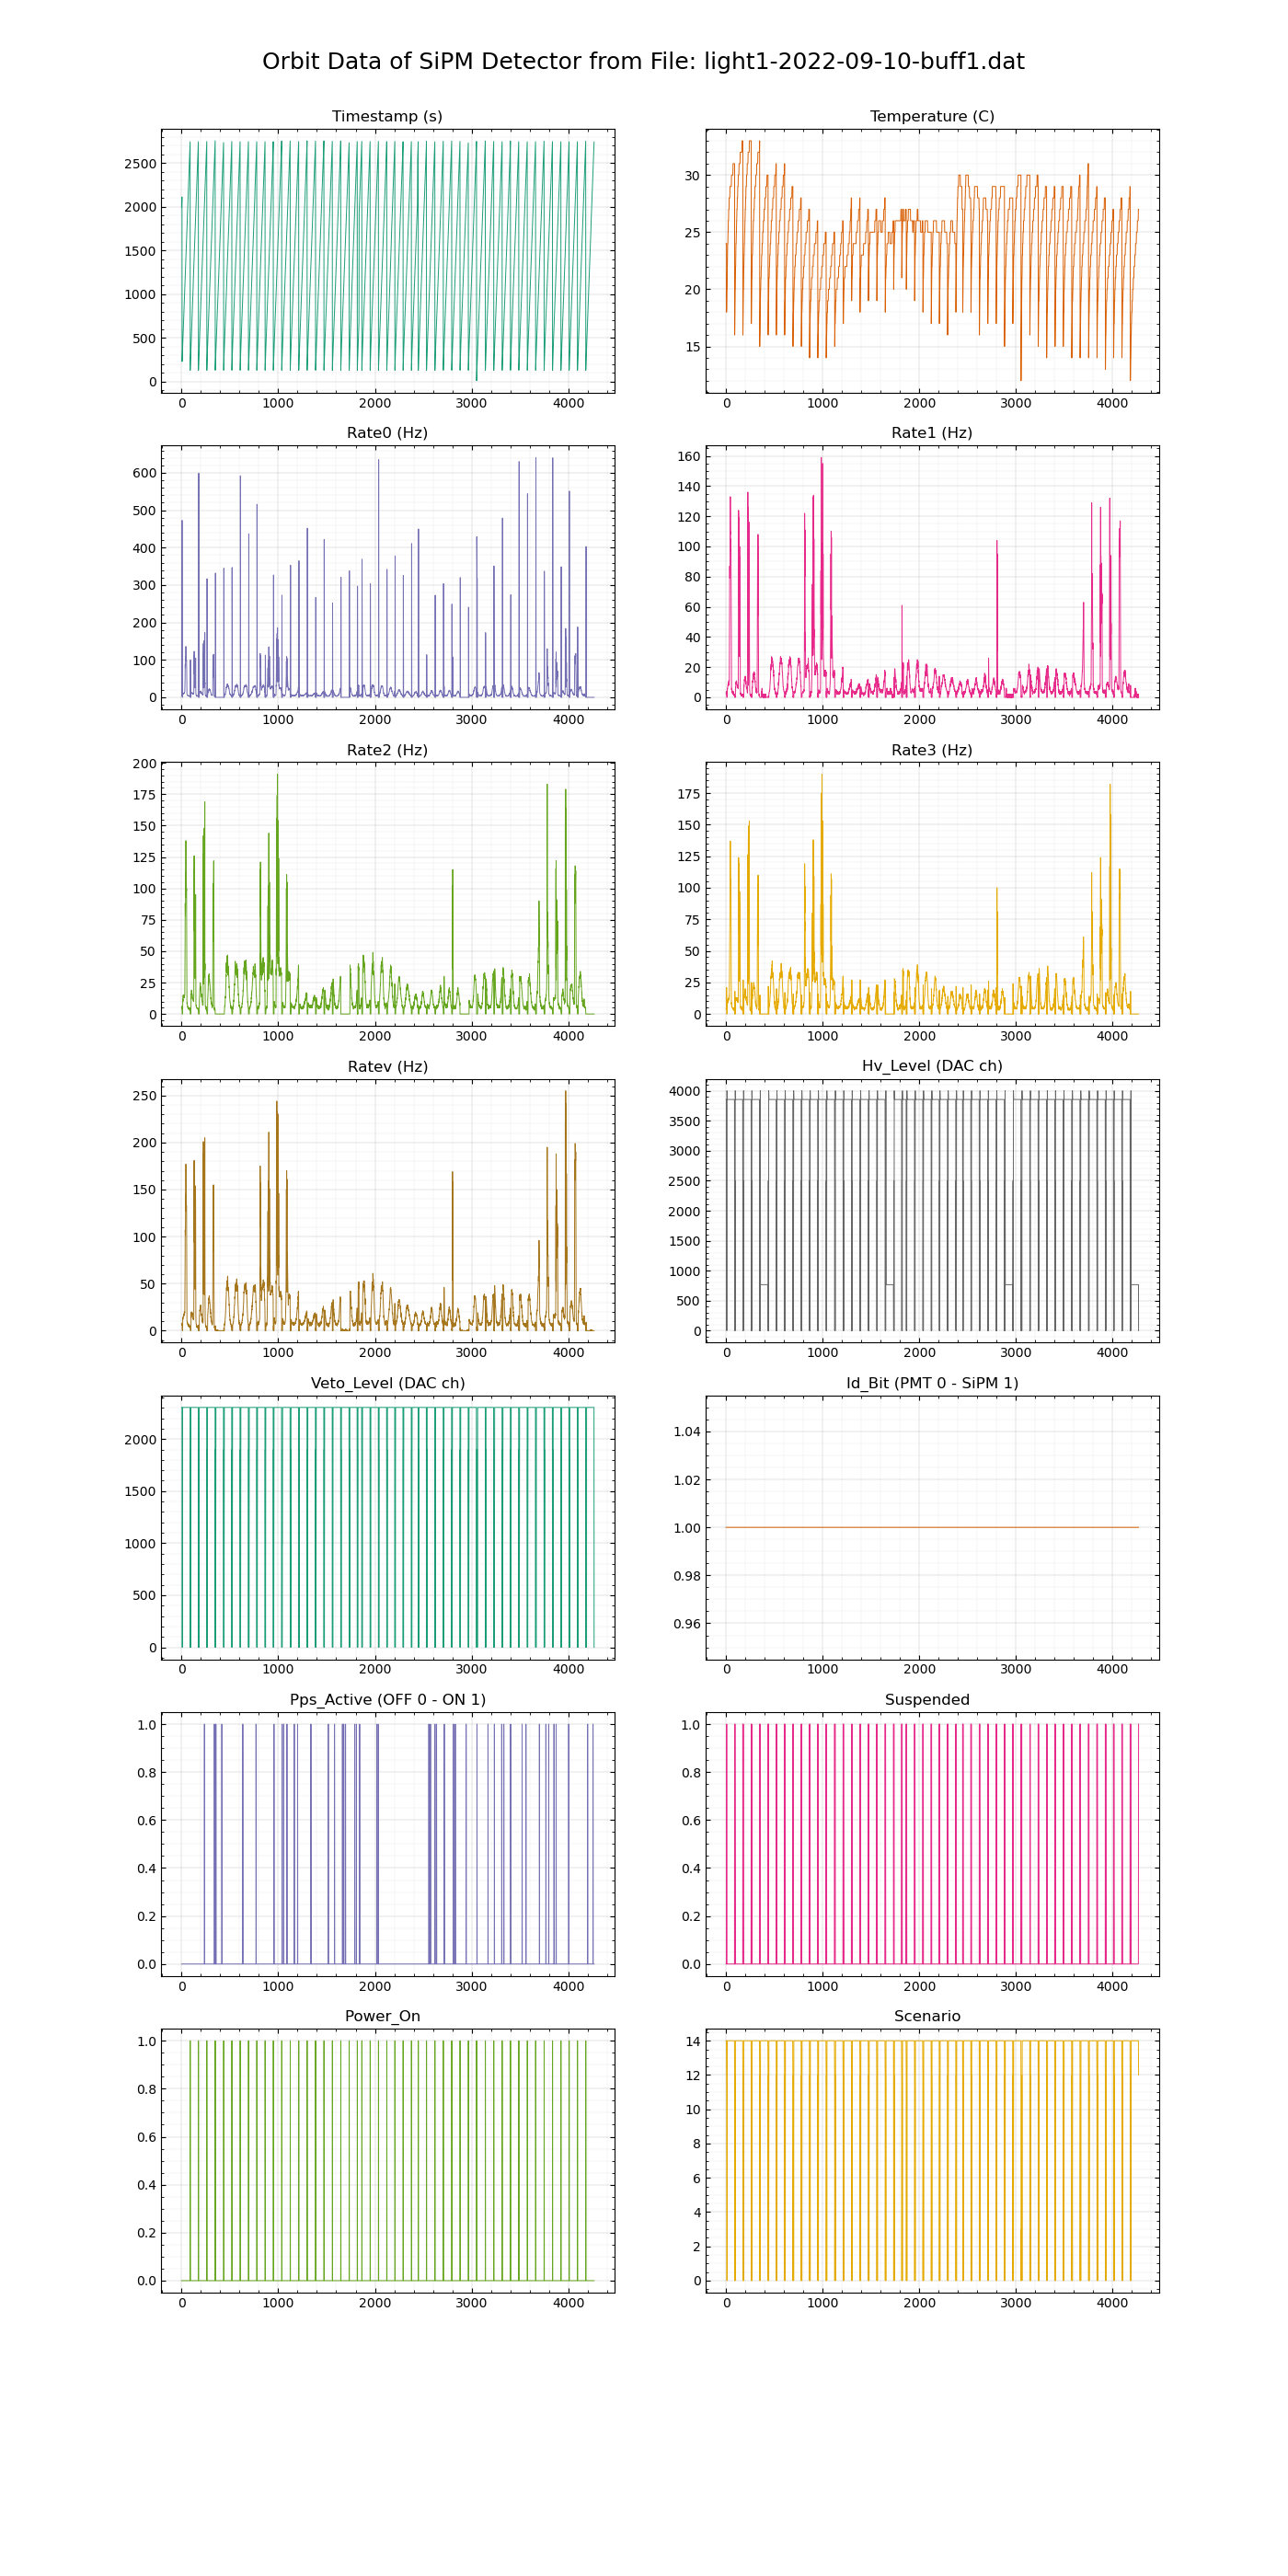

In [4]:
# Print the SiPM Data
fig, axes = rp.plot_buffer(data_SiPM, title = 'Orbit Data of SiPM Detector from File: '+ filenames['buff1'],UNITS=rp.ORBIT_UNITS)

In [16]:
# Now we load the log file and find it's timestamps
log = rp.log_expand(filename=raw_dir+filenames['log'])      # Load the logfile
log = rp.log_with_timestamp(log)                            # Find the timestamp each command finished executing

# Now we want to get only the commands that have anything to do with the scenario
sc_commands = []
PAYLOAD     = rp.SIPM
for line in log:
    # If you have a custom scenario command
    if f"csp txrx {PAYLOAD}" in line['command'] or f"csp txrx {rp.BOTH}" in line['command']:
        # If it was executed correctly
        if 'OK\n' in line['output']:
            # Decode the command
            # data = rp.parse_custom_scenario(line['command'].split(' ')[-1][:-1])

            # Append this to the high voltage commands
            sc_commands.append(line)
            sc_commands[-1]['scenario'] = int(line['command'].split(' ')[5])

# Now we can create a high voltage plot as a function of time
scenario = np.array([cmd['scenario']     for cmd in sc_commands])
time     = np.array([cmd['timestamp']    for cmd in sc_commands])


ValueError: invalid literal for int() with base 10: '000A000000\n'

In [15]:
log[23]['command']

'SE0>csp txrx 12 8 3000 0F\n'

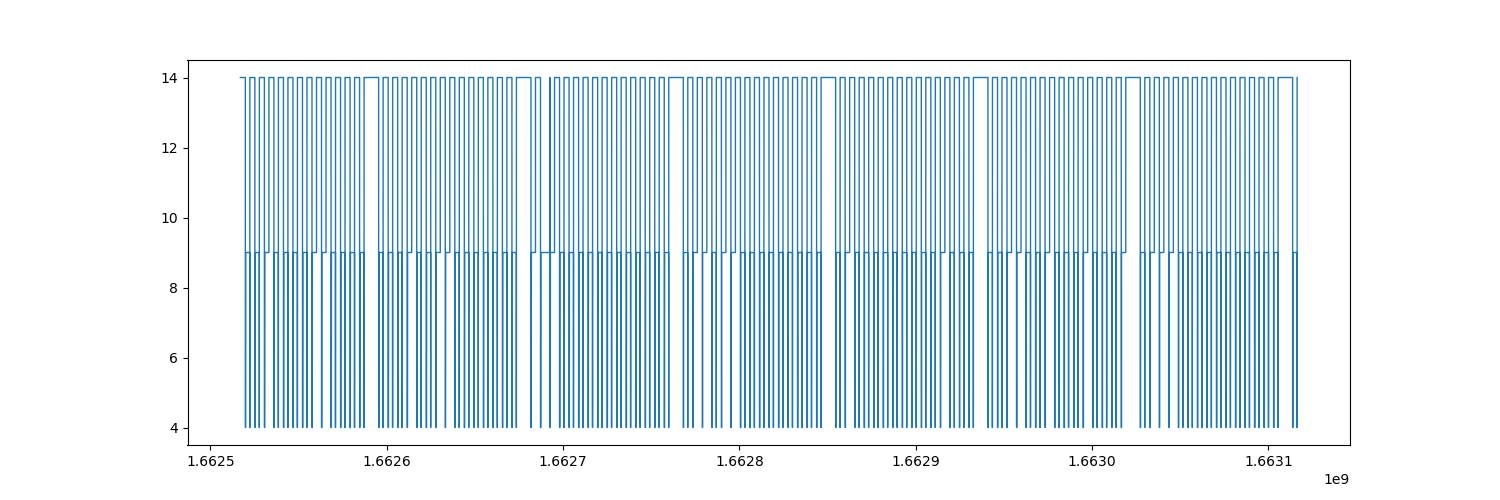

In [10]:
fig = plt.figure(figsize=(15,5))
plt.step(time,scenario,where='post',lw=1)

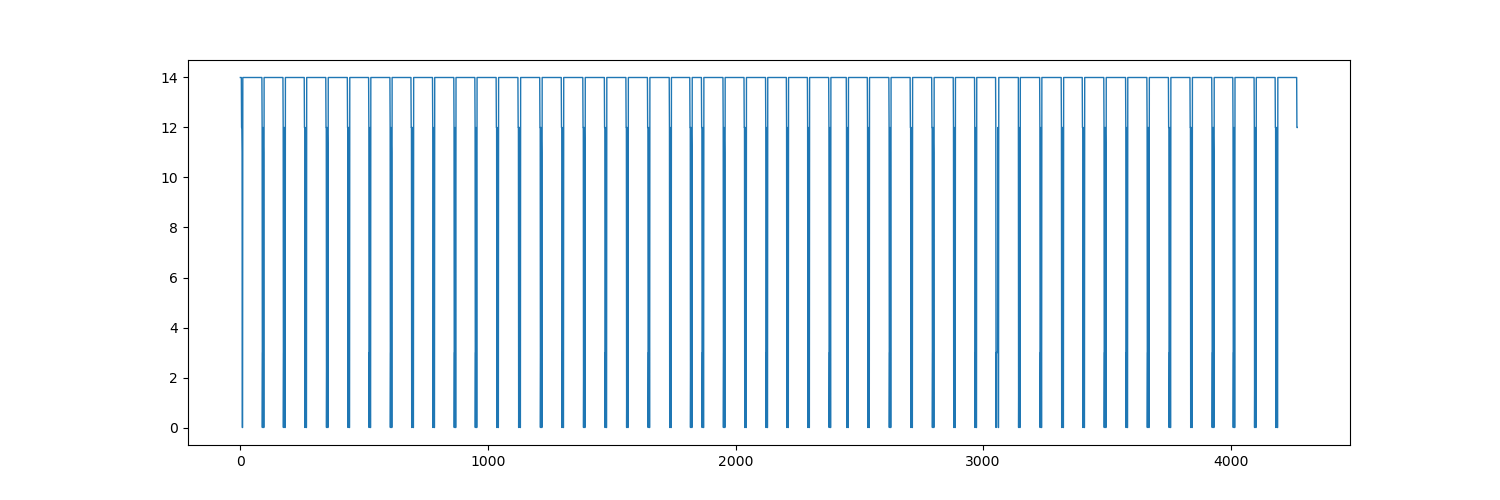

In [12]:
fig = plt.figure(figsize=(15,5))
plt.plot(data_SiPM['scenario'],lw=1)

In [13]:
np.unique(scenario)

array([ 4,  8,  9, 14])

In [14]:
np.unique(data_SiPM['scenario'])

array([ 0.,  3., 11., 12., 14.])